In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# ! 7z x ./drive/MyDrive/Skoltech/ML/data/Data/kdd99.7z

# ! unzip ./drive/MyDrive/Skoltech/ML/data/Data/WADI.zip

# ! unzip ./drive/MyDrive/Skoltech/ML/data/Data/SWaT.zip

# ! cp ./drive/MyDrive/Skoltech/ML/data/Data/MNIST_train.pkl .
# ! cp ./drive/MyDrive/Skoltech/ML/data/Data/MNIST_test.pkl .

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score#, precision_recall_curve

from tqdm.notebook import tqdm

from torchvision.transforms import Resize

In [ ]:
class LSTMGenerator(nn.Module):

  def __init__(self, latent_space_dim, out_space_dim, lstm_layers, lstm_hidden_dim):
    super(LSTMGenerator, self).__init__()

    self.out_space_dim = out_space_dim
    self.lstm_hidden_dim = lstm_hidden_dim
    self.lstm_layers = lstm_layers

    self.lstm = nn.LSTM(input_size=latent_space_dim, hidden_size=lstm_hidden_dim, num_layers=lstm_layers, batch_first=True)
    self.linear = nn.Linear(in_features=lstm_hidden_dim, out_features=out_space_dim)
  

  def forward(self, input):
    batch_size, seq_len = input.size(0), input.size(1)

    recurrent_features, _ = self.lstm(input)
    outputs = self.linear(recurrent_features.contiguous().view(batch_size*seq_len, self.lstm_hidden_dim)) # no tanh
    outputs = outputs.view(batch_size, seq_len, self.out_space_dim)

    return outputs


class LSTMDiscriminator(nn.Module):

    def __init__(self, out_space_dim, lstm_layers, lstm_hidden_dim):
        super(LSTMDiscriminator, self).__init__()
        
        self.lstm_hidden_dim = lstm_hidden_dim

        self.lstm = nn.LSTM(input_size=out_space_dim, hidden_size=lstm_hidden_dim, num_layers=lstm_layers, batch_first=True)
        self.linear = nn.Linear(in_features=lstm_hidden_dim, out_features=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, input):
        batch_size, seq_len = input.size(0), input.size(1)

        recurrent_features, _ = self.lstm(input)
        outputs = self.sigmoid(self.linear(recurrent_features.contiguous().view(batch_size*seq_len, self.lstm_hidden_dim)))
        
        outputs = outputs.view(batch_size, seq_len, 1)

        return outputs

In [ ]:
class CNN_LSTMGenerator(nn.Module):

  def __init__(self, latent_space_dim, lstm_hidden_dim, lstm_layers, cnn_features):
    super(CNN_LSTMGenerator, self).__init__()

    self.lstm_hidden_dim = lstm_hidden_dim

    self.lstm = nn.LSTM(input_size=latent_space_dim, hidden_size=lstm_hidden_dim, num_layers=lstm_layers, batch_first=True)

    self.cnn = nn.Sequential(
            # state size. (lstm_features) x 2 x 2
            nn.ConvTranspose2d(lstm_hidden_dim, cnn_features * 4, 4, 1, 0, bias=False),
            # 2 - 1 + 3 + 1
            nn.BatchNorm2d(cnn_features * 4),
            nn.ReLU(True),
            # state size. (cnn_features*4) x 4 x 4
            nn.ConvTranspose2d(cnn_features * 4, cnn_features * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(cnn_features * 2),
            nn.ReLU(True),
            # state size. (cnn_features*2) x 8 x 8
            nn.ConvTranspose2d(cnn_features * 2, cnn_features, 4, 2, 1, bias=False),
            nn.BatchNorm2d(cnn_features),
            nn.ReLU(True),
            # state size. (cnn_features) x 16 x 16
            nn.ConvTranspose2d(cnn_features, 1, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. 1 x 32 x 32
        )
  

  def forward(self, input):
    batch_size, seq_len = input.size(0), input.size(1)

    recurrent_features, _ = self.lstm(input)
    recurrent_features = recurrent_features.contiguous().view(batch_size*seq_len, self.lstm_hidden_dim, 1, 1)
    outputs = self.cnn(recurrent_features).view(batch_size, seq_len, 32, 32)

    return outputs


class CNN_LSTMDiscriminator(nn.Module):

    def __init__(self, lstm_hidden_dim, lstm_layers, cnn_features):
        super(CNN_LSTMDiscriminator, self).__init__()

        self.lstm_hidden_dim = lstm_hidden_dim

        self.lstm = nn.LSTM(input_size=cnn_features * 4, hidden_size=lstm_hidden_dim, num_layers=lstm_layers, batch_first=True)
        self.cnn = nn.Sequential(
            # input is 1 x 64 x 64
            nn.Conv2d(1, cnn_features, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. cnn_features x 32 x 32
            nn.Conv2d(cnn_features, cnn_features * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(cnn_features * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (cnn_features*2) x 16 x 16
            nn.Conv2d(cnn_features * 2, cnn_features * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(cnn_features * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (cnn_features*4) x 8 x 8
            nn.Conv2d(cnn_features * 4, cnn_features * 4, 4, 1, 0, bias=False),
        )
        self.linear = nn.Linear(in_features=lstm_hidden_dim, out_features=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, input):
        batch_size, seq_len = input.size(0), input.size(1)

        convolutional_features = self.cnn(input.view(batch_size*seq_len, 1, 32, 32)).view(batch_size, seq_len, -1)
        
        recurrent_features, _ = self.lstm(convolutional_features)
        outputs = self.sigmoid(self.linear(recurrent_features.contiguous().view(batch_size*seq_len, self.lstm_hidden_dim)))
        
        outputs = outputs.view(batch_size, seq_len, 1)

        return outputs

In [ ]:
class SubData(torch.utils.data.Dataset):
  def __init__(self, samples, labels):
    super(SubData, self).__init__()

    self.samples = samples
    self.labels = labels

  def __len__(self):
    return self.labels.shape[0]

  def __getitem__(self, idx):
    return self.samples[idx], self.labels[idx]

class Data(torch.utils.data.Dataset):
  def __init__(self, normal_data_path, abnormal_data_path, normal_label, abnormal_label, seq_length, seq_step, num_signals):
    super(Data, self).__init__()

    self.scaler1 = None
    self.scaler2 = None
    self.pca = None

    normal_samples, normal_labels = self.preprocess_data(self.load_normal_data(normal_data_path),
                                                         True, normal_label, abnormal_label, seq_step, seq_length, num_signals)
    self.normal_data = SubData(normal_samples, normal_labels)
    
    abnormal_samples, abnormal_labels = self.preprocess_data(self.load_abnormal_data(abnormal_data_path),
                                                             False, normal_label, abnormal_label, seq_step, seq_length, num_signals)
    # self.all_data = SubData(np.concatenate([normal_samples, abnormal_samples]), np.concatenate([normal_labels, abnormal_labels]))
    self.all_data = SubData(abnormal_samples, abnormal_labels)

    

  def load_normal_data(self, data_path):
    raise NotImplementedError()

  def load_abnormal_data(self, data_path):
    raise NotImplementedError()

  def preprocess_data(self, samples, is_normal, normal_label, abnormal_label, seq_step, seq_length, num_signals):

    if is_normal:
      self.scaler1 = StandardScaler().fit(samples)

    samples = self.scaler1.transform(samples)

    label = normal_label if is_normal else abnormal_label
    labels = np.ones(samples.shape[0]) * label
    
    if is_normal:
      self.pca = PCA(num_signals, svd_solver='full').fit(samples)

    samples = self.pca.transform(samples)

    if is_normal:
      self.scaler2 = StandardScaler().fit(samples)

    samples = self.scaler2.transform(samples)

    num_samples = (samples.shape[0] - seq_length) // seq_step

    aa = np.empty([num_samples, seq_length, num_signals], dtype='float')
    bb = np.empty([num_samples, seq_length, 1], dtype='float')

    for j in range(num_samples):
        bb[j, :, :] = np.reshape(labels[(j * seq_step):(j * seq_step + seq_length)], [-1, 1])
        aa[j, :, :] = samples[(j * seq_step):(j * seq_step + seq_length), :]

    return aa.astype('float32'), bb.astype('float32')

class KddDataset(Data):
  def __init__(self, normal_data_path, abnormal_data_path, normal_label, abnormal_label, seq_length, seq_step, num_signals):
    super(KddDataset, self).__init__(normal_data_path, abnormal_data_path, normal_label, abnormal_label, seq_length, seq_step, num_signals)

  def load_normal_data(self, data_path):
    return np.load(data_path)[:, :-1]

  def load_abnormal_data(self, data_path):
    return np.load(data_path)[:, :-1]


class SwatDataset(Data):
  def __init__(self, normal_data_path, abnormal_data_path, normal_label, abnormal_label, seq_length, seq_step, num_signals):
    super(SwatDataset, self).__init__(normal_data_path, abnormal_data_path, normal_label, abnormal_label, seq_length, seq_step, num_signals)

  def load_normal_data(self, data_path):
    return pd.read_excel(data_path, header=1).drop(['Timestamp', 'Normal/Attack'], axis=1).dropna(axis=1).values[21600:]

  def load_abnormal_data(self, data_path):
    return pd.read_excel(data_path, header=1).drop(['Timestamp', 'Normal/Attack'], axis=1).dropna(axis=1).values[21600:]


class WadiDataset(Data):
  def __init__(self, normal_data_path, abnormal_data_path, normal_label, abnormal_label, seq_length, seq_step, num_signals):
    self.drop_columns = ['Row', 'Date', 'Time',
                         r'\\WIN-25J4RO10SBF\LOG_DATA\SUTD_WADI\LOG_DATA\2_LS_001_AL',
                         r'\\WIN-25J4RO10SBF\LOG_DATA\SUTD_WADI\LOG_DATA\2_LS_002_AL',
                         r'\\WIN-25J4RO10SBF\LOG_DATA\SUTD_WADI\LOG_DATA\2_P_001_STATUS',
                         r'\\WIN-25J4RO10SBF\LOG_DATA\SUTD_WADI\LOG_DATA\2_P_002_STATUS']
    # metadata on contains NaNs
    
    super(WadiDataset, self).__init__(normal_data_path, abnormal_data_path, normal_label, abnormal_label, seq_length, seq_step, num_signals)

  def load_normal_data(self, data_path):
    return pd.read_csv(data_path, skiprows=4).drop(self.drop_columns, axis=1).dropna(axis=0).values[21600:]

  def load_abnormal_data(self, data_path):
    return pd.read_csv(data_path).drop(self.drop_columns, axis=1).dropna(axis=0).values[21600:]


class MnistDataset(Data):
  def __init__(self, normal_data_path, abnormal_data_path, normal_label, abnormal_label, seq_length=None, seq_step=None, num_signals=None):
    super(MnistDataset, self).__init__(normal_data_path, abnormal_data_path, normal_label, abnormal_label, seq_length, seq_step, num_signals)

  def load_normal_data(self, data_path):
    with open(data_path, 'rb') as f:
      samples, labels = pickle.load(f)
      return samples, labels

  def load_abnormal_data(self, data_path):
    with open(data_path, 'rb') as f:
      samples, labels = pickle.load(f)
      return samples, labels

  def preprocess_data(self, samples, is_normal, normal_label, abnormal_label, seq_step, seq_length, num_signals):
    samples, labels = samples[0], samples[1]
    batch_size, seq_length = samples.shape[0], samples.shape[1]

    if is_normal:
      self.scaler1 = MinMaxScaler([-1, 1]).fit(samples.flatten().reshape((-1, 1)))
      
    samples = self.scaler1.transform(samples.flatten().reshape((-1, 1))).reshape(batch_size, seq_length, 28, 28)
    samples = Resize((32, 32))(torch.from_numpy(samples))

    label = normal_label if is_normal else abnormal_label
    labels = np.ones((batch_size, seq_length, 1)) * label

    return samples, labels

In [ ]:
def plot_1d_generated(fake, settings):
  fig, ax = plt.subplots(1, settings['num_signals'], figsize=(15, 1))

  for i in range(settings['num_signals']):
    ax[i].plot(fake[0, :, i])

  plt.show()

def plot_2d_generated(fake, settings):
  n_images = 3
  step = settings['seq_length'] // n_images
  fig, ax = plt.subplots(1, n_images, figsize=(15, 1))

  for i in range(n_images):
    ax[i].imshow(fake[0, step*i])
    ax[i].axis('off')

  plt.show()

In [ ]:
settings = {'kdd99': {
                      "data": KddDataset,
                      "normal_data_path": "./kdd99_train.npy",
                      "abnormal_data_path": "./kdd99_test.npy",

                      "seq_length": 30,
                      "num_signals": 6,
                      "seq_step": 10,

                      "normal_label": 0,
                      "abnormal_label": 1,

                      "generator": LSTMGenerator,
                      "discriminator": LSTMDiscriminator,

                      "latent_dim": 15,
                      "lstm_hidden_dim_g": 100,
                      "lstm_layers_g": 3,
                      "lstm_hidden_dim_d": 100,
                      "lstm_layers_d": 3,

                      "batch_size": 500,
                      "num_epochs": 100,
                      "D_rounds": 1,
                      "G_rounds": 3,

                      "plot_generated": plot_1d_generated
                      },
            'WADI': {
                      "data": WadiDataset,
                      "normal_data_path": "./WADI_14days.csv",
                      "abnormal_data_path": "./WADI_attackdata.csv",
                     
                      "seq_length": 30,
                      "num_signals": 8,
                      "seq_step": 10,

                      "normal_label": 0,
                      "abnormal_label": 1,

                      "generator": LSTMGenerator,
                      "discriminator": LSTMDiscriminator,

                      "latent_dim": 15,
                      "lstm_hidden_dim_g": 100,
                      "lstm_layers_g": 3,
                      "lstm_hidden_dim_d": 100,
                      "lstm_layers_d": 3,

                      "batch_size": 500,
                      "num_epochs": 100,
                      "D_rounds": 1,
                      "G_rounds": 3,

                      "plot_generated": plot_1d_generated
                      },
            'SWaT': {
                      "data": SwatDataset,
                      "normal_data_path": "./SWaT_Dataset_Normal_v0.xlsx",
                      "abnormal_data_path": "./SWaT_Dataset_Attack_v0.xlsx",
                      
                      "seq_length": 30,
                      "num_signals": 8,
                      "seq_step": 10,

                      "normal_label": 0,
                      "abnormal_label": 1,

                      "generator": LSTMGenerator,
                      "discriminator": LSTMDiscriminator,

                      "latent_dim": 15,
                      "lstm_hidden_dim_g": 100,
                      "lstm_layers_g": 3,
                      "lstm_hidden_dim_d": 100,
                      "lstm_layers_d": 3,

                      "batch_size": 500,
                      "num_epochs": 100,
                      "D_rounds": 1,
                      "G_rounds": 3,

                      "plot_generated": plot_1d_generated
                      },
            "MNIST": {
                      "data": MnistDataset,
                      # "normal_data_path": './MNIST_train.pkl',
                      # "abnormal_data_path": './MNIST_test.pkl',
                      "normal_data_path": './drive/MyDrive/Skoltech/ML/train_seq.pkl',
                      "abnormal_data_path": './drive/MyDrive/Skoltech/ML/test_seq.pkl',
                      
                      "seq_length": 10,
                      "num_signals": None,
                      "seq_step": None,

                      "normal_label": 0,
                      "abnormal_label": 1,

                      "generator": CNN_LSTMGenerator,
                      "discriminator": CNN_LSTMDiscriminator,

                      "latent_dim": 75,
                      "lstm_hidden_dim_g": 200,
                      "lstm_layers_g": 3,
                      "lstm_hidden_dim_d": 200,
                      "lstm_layers_d": 1,

                      "cnn_features_g": 64,
                      "cnn_features_d": 64,

                      "batch_size": 128,
                      "num_epochs": 100,
                      "D_rounds": 1,
                      "G_rounds": 3,

                      "plot_generated": plot_2d_generated
                      }
            }

In [ ]:
def init(settings, device='cuda:0'):
  if settings['generator'].__name__ == 'LSTMGenerator':
    generator = LSTMGenerator(latent_space_dim=settings['latent_dim'],
                              out_space_dim=settings['num_signals'],
                              lstm_layers=settings['lstm_layers_g'],
                              lstm_hidden_dim=settings['lstm_hidden_dim_g']).to(device)
  else:
    generator = CNN_LSTMGenerator(latent_space_dim=settings['latent_dim'],
                                  lstm_layers=settings['lstm_layers_g'],
                                  lstm_hidden_dim=settings['lstm_hidden_dim_g'],
                                  cnn_features=settings['cnn_features_g']).to(device)
    
  if settings['discriminator'].__name__ == 'LSTMDiscriminator':
    discriminator = LSTMDiscriminator(out_space_dim=settings['num_signals'],
                                      lstm_layers=settings['lstm_layers_d'],
                                      lstm_hidden_dim=settings['lstm_hidden_dim_d']).to(device)
  else:
    discriminator = CNN_LSTMDiscriminator(lstm_hidden_dim=settings['lstm_hidden_dim_d'],
                                          lstm_layers=settings['lstm_layers_d'],
                                          cnn_features=settings['cnn_features_d']).to(device)

  criterion = nn.BCELoss().to(device)
# lr=0.0015
  optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=0.0015)
  optimizer_G = torch.optim.Adam(generator.parameters(), lr=0.0015)

  scheduler_D = torch.optim.lr_scheduler.ExponentialLR(
    optimizer=optimizer_D, 
    gamma=0.97)
  
  scheduler_G = torch.optim.lr_scheduler.ExponentialLR(
    optimizer=optimizer_G, 
    gamma=0.99)

  dset = settings['data'](settings['normal_data_path'],
                          settings['abnormal_data_path'],
                          normal_label=settings['normal_label'],
                          abnormal_label=settings['abnormal_label'],
                          seq_length=settings['seq_length'],
                          seq_step=settings['seq_step'],
                          num_signals=settings['num_signals'])
  

  train_loader = torch.utils.data.DataLoader(dset.normal_data, batch_size=settings['batch_size'], shuffle=False)

  fake_label = settings['abnormal_label']
  real_label = settings['normal_label']

  return {'n_epochs': settings['num_epochs'], 'criterion': criterion, 'generator': generator,
          'discriminator': discriminator, 'optimizer_D':optimizer_D, 'optimizer_G': optimizer_G,
          'scheduler_D':scheduler_D, 'scheduler_G': scheduler_G,
          'train_loader': train_loader, 'device': device,
          'fake_label': fake_label, 'real_label': real_label,
          'settings': settings}, dset

In [ ]:
def train(n_epochs, criterion, generator, discriminator, optimizer_D, optimizer_G, scheduler_D, scheduler_G, train_loader, device, real_label, fake_label, settings):
  latent_space_dim = settings['latent_dim']
  D_rounds = settings['D_rounds']
  G_rounds = settings['G_rounds']

  visualization_noise = torch.randn(1, settings['seq_length'], latent_space_dim, device=device)

  for epoch in range(n_epochs):

    generator.train()
    discriminator.train()

    losses_train = []
    for i, data in tqdm(enumerate(train_loader), leave=False):

      iter = epoch * len(train_loader) + i

      # Real data
      real = data[0].to(torch.float).to(device)
      real_labels = data[1].to(torch.float).to(device)

      batch_size, seq_len = real.size(0), real.size(1)

      ############################
      # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
      ###########################

      # Fake data
      noise = torch.randn(batch_size, seq_len, latent_space_dim, device=device)
      fake = generator(noise)
      fake_labels = torch.full((batch_size, seq_len, 1), fake_label, device=device).to(torch.float)

      for r in range(D_rounds):
        #Train with real data
        discriminator.zero_grad()

        output = discriminator(real)
        errD_real = criterion(output, real_labels)
        
        #Train with fake data
        output = discriminator(fake.detach())
        errD_fake = criterion(output, fake_labels)

        errD = errD_real + errD_fake
        errD.backward()

        optimizer_D.step()
        scheduler_D.step()

      ############################
      # (2) Update G network: maximize log(D(G(z)))
      ###########################

      for r in range(G_rounds):
        generator.zero_grad()

        # Fake data
        noise = torch.randn(batch_size, seq_len, latent_space_dim, device=device)
        fake = generator(noise)

        output = discriminator(fake)
        errG = criterion(output, real_labels)
        errG.backward()        
        optimizer_G.step()
        scheduler_G.step()

    # Calc losses at epoch end:
    output = discriminator(real)
    errD_real = criterion(output, real_labels)
    D_x = output.mean().item()

    noise = torch.randn(batch_size, seq_len, latent_space_dim, device=device)
    fake = generator(noise).detach()

    output = discriminator(fake)
    errD_fake = criterion(output, fake_labels)
    D_G_z1 = output.mean().item()

    errD = (errD_real + errD_fake).item()
    errG = criterion(output, real_labels).item()
    D_G_z2 = output.mean().item()

    #Report metrics
    print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f / %.4f' 
          % (epoch, n_epochs, i, len(train_loader),
              errD, errG, D_x, D_G_z1, D_G_z2), end='\n')
    
    # Visualize generation
    visualization_fake = generator(visualization_noise).detach().cpu()

    settings['plot_generated'](visualization_fake, settings)

    # if epoch % 10 == 9:
    #   with open('./drive/MyDrive/Skoltech/ML/model_MNIST_fives_1_1' + str(epoch) + '.pkl', 'wb') as f:
    #     pickle.dump([train_params['generator'], train_params['discriminator'], train_params['settings']], f)
    #   print('Saved model')

In [ ]:
train_params, dset = init(settings['MNIST'], 'cuda:0')

In [ ]:
 with open('./drive/MyDrive/Skoltech/ML/test_seq.pkl', 'rb') as f:
    samples, labels = pickle.load(f)

[0/100][78/79] Loss_D: 0.0589 Loss_G: 3.3000 D(x): 0.0137 D(G(z)): 0.9565 / 0.9565


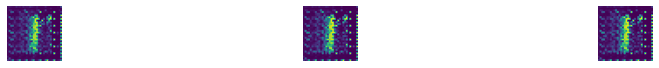

[1/100][78/79] Loss_D: 0.1000 Loss_G: 3.0182 D(x): 0.0320 D(G(z)): 0.9372 / 0.9372


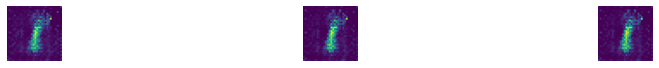

[2/100][78/79] Loss_D: 0.0904 Loss_G: 3.1195 D(x): 0.0291 D(G(z)): 0.9430 / 0.9430


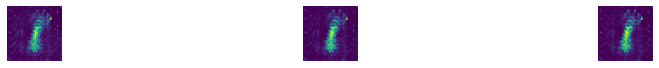

[3/100][78/79] Loss_D: 0.0894 Loss_G: 3.1320 D(x): 0.0290 D(G(z)): 0.9438 / 0.9438


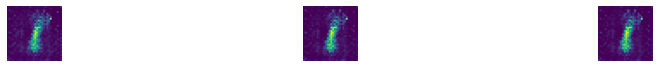

[4/100][78/79] Loss_D: 0.0895 Loss_G: 3.1321 D(x): 0.0290 D(G(z)): 0.9437 / 0.9437


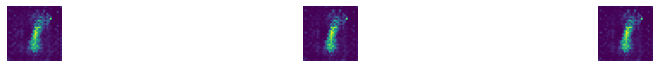

[5/100][78/79] Loss_D: 0.0892 Loss_G: 3.1340 D(x): 0.0290 D(G(z)): 0.9439 / 0.9439


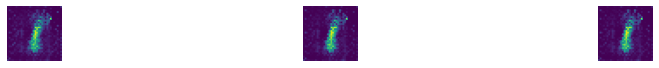

[6/100][78/79] Loss_D: 0.0893 Loss_G: 3.1333 D(x): 0.0290 D(G(z)): 0.9438 / 0.9438


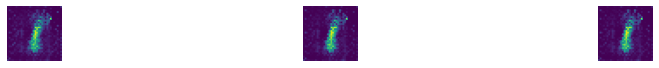

[7/100][78/79] Loss_D: 0.0894 Loss_G: 3.1326 D(x): 0.0290 D(G(z)): 0.9438 / 0.9438


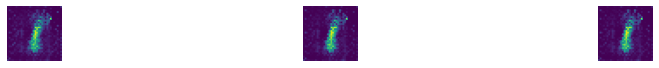

[8/100][78/79] Loss_D: 0.0892 Loss_G: 3.1343 D(x): 0.0290 D(G(z)): 0.9439 / 0.9439


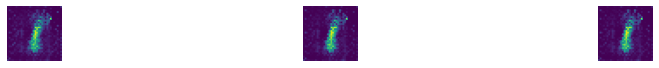

[9/100][78/79] Loss_D: 0.0893 Loss_G: 3.1336 D(x): 0.0290 D(G(z)): 0.9439 / 0.9439


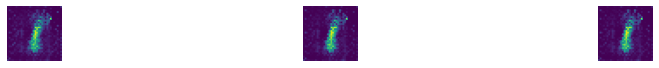

[10/100][78/79] Loss_D: 0.0893 Loss_G: 3.1335 D(x): 0.0290 D(G(z)): 0.9439 / 0.9439


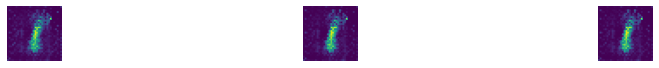

[11/100][78/79] Loss_D: 0.0893 Loss_G: 3.1339 D(x): 0.0290 D(G(z)): 0.9439 / 0.9439


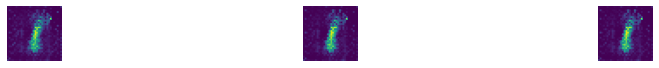

[12/100][78/79] Loss_D: 0.0894 Loss_G: 3.1325 D(x): 0.0290 D(G(z)): 0.9438 / 0.9438


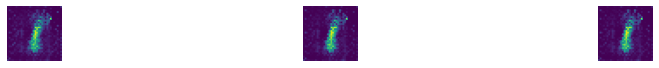

[13/100][78/79] Loss_D: 0.0894 Loss_G: 3.1323 D(x): 0.0290 D(G(z)): 0.9437 / 0.9437


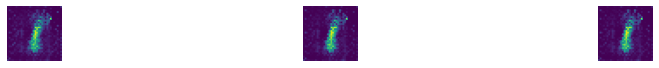

[14/100][78/79] Loss_D: 0.0893 Loss_G: 3.1333 D(x): 0.0290 D(G(z)): 0.9438 / 0.9438


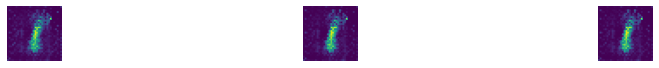

[15/100][78/79] Loss_D: 0.0893 Loss_G: 3.1340 D(x): 0.0290 D(G(z)): 0.9439 / 0.9439


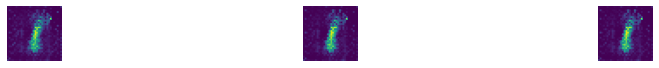

[16/100][78/79] Loss_D: 0.0892 Loss_G: 3.1340 D(x): 0.0290 D(G(z)): 0.9439 / 0.9439


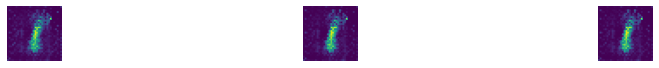

[17/100][78/79] Loss_D: 0.0893 Loss_G: 3.1338 D(x): 0.0290 D(G(z)): 0.9439 / 0.9439


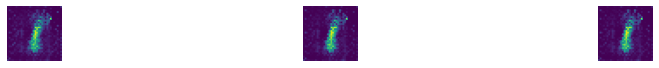

[18/100][78/79] Loss_D: 0.0894 Loss_G: 3.1327 D(x): 0.0290 D(G(z)): 0.9438 / 0.9438


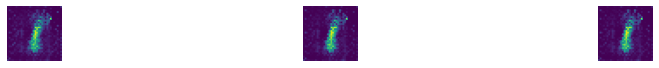

[19/100][78/79] Loss_D: 0.0892 Loss_G: 3.1347 D(x): 0.0290 D(G(z)): 0.9440 / 0.9440


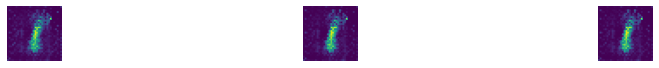

[20/100][78/79] Loss_D: 0.0894 Loss_G: 3.1331 D(x): 0.0290 D(G(z)): 0.9438 / 0.9438


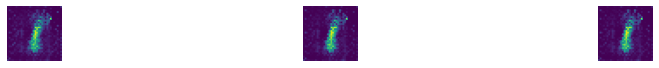

[21/100][78/79] Loss_D: 0.0893 Loss_G: 3.1336 D(x): 0.0290 D(G(z)): 0.9439 / 0.9439


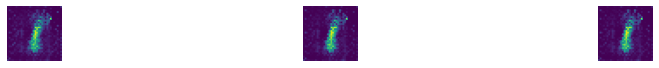

[22/100][78/79] Loss_D: 0.0894 Loss_G: 3.1326 D(x): 0.0290 D(G(z)): 0.9438 / 0.9438


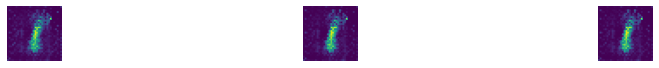

[23/100][78/79] Loss_D: 0.0894 Loss_G: 3.1330 D(x): 0.0290 D(G(z)): 0.9438 / 0.9438


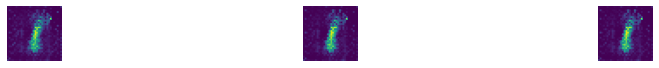

[24/100][78/79] Loss_D: 0.0892 Loss_G: 3.1340 D(x): 0.0290 D(G(z)): 0.9439 / 0.9439


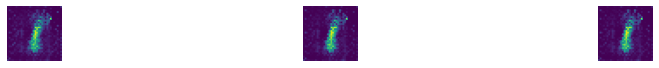

KeyboardInterrupt: ignored

In [ ]:
train(**train_params)

In [ ]:
with open('./drive/MyDrive/Skoltech/ML/model_MNIST_ones.pkl', 'wb') as f:
        pickle.dump([train_params['generator'], train_params['discriminator'], train_params['settings']], f)

In [ ]:
for i in CNN_LSTMGenerator(15, 100, 3, 200).to('cuda:0')(torch.randn(1, 30, 15, device='cuda:0'))[0]:
  plt.figure()
  plt.imshow(i.detach().cpu().numpy(), cmap='Greys')

In [ ]:
import torch
import torch.nn.functional as F
from torch.autograd import Variable
import numpy as np
from math import exp

def gaussian(window_size, sigma):
    gauss = torch.Tensor([exp(-(x - window_size//2)**2/float(2*sigma**2)) for x in range(window_size)])
    return gauss/gauss.sum()

def create_window(window_size, channel):
    _1D_window = gaussian(window_size, 1.5).unsqueeze(1)
    _2D_window = _1D_window.mm(_1D_window.t()).float().unsqueeze(0).unsqueeze(0)
    window = Variable(_2D_window.expand(channel, 1, window_size, window_size).contiguous())
    return window

def _ssim(img1, img2, window, window_size, channel, size_average = True):
    mu1 = F.conv2d(img1, window, padding = window_size//2, groups = channel)
    mu2 = F.conv2d(img2, window, padding = window_size//2, groups = channel)

    mu1_sq = mu1.pow(2)
    mu2_sq = mu2.pow(2)
    mu1_mu2 = mu1*mu2

    sigma1_sq = F.conv2d(img1*img1, window, padding = window_size//2, groups = channel) - mu1_sq
    sigma2_sq = F.conv2d(img2*img2, window, padding = window_size//2, groups = channel) - mu2_sq
    sigma12 = F.conv2d(img1*img2, window, padding = window_size//2, groups = channel) - mu1_mu2

    C1 = 0.01**2
    C2 = 0.03**2

    ssim_map = ((2*mu1_mu2 + C1)*(2*sigma12 + C2))/((mu1_sq + mu2_sq + C1)*(sigma1_sq + sigma2_sq + C2))

    if size_average:
        return ssim_map.mean()
    else:
        return ssim_map.mean(1).mean(1).mean(1)

class SSIM(torch.nn.Module):
    def __init__(self, window_size = 11, size_average = True):
        super(SSIM, self).__init__()
        self.window_size = window_size
        self.size_average = size_average
        self.channel = 1
        self.window = create_window(window_size, self.channel)

    def forward(self, img1, img2):
        (_, channel, _, _) = img1.size()

        if channel == self.channel and self.window.data.type() == img1.data.type():
            window = self.window
        else:
            window = create_window(self.window_size, channel)
            
            if img1.is_cuda:
                window = window.cuda(img1.get_device())
            window = window.type_as(img1)
            
            self.window = window
            self.channel = channel


        return _ssim(img1, img2, window, self.window_size, channel, self.size_average)

def ssim(img1, img2, window_size = 11, size_average = True):
    (_, channel, _, _) = img1.size()
    window = create_window(window_size, channel)
    
    if img1.is_cuda:
        window = window.cuda(img1.get_device())
    window = window.type_as(img1)
    
    return _ssim(img1, img2, window, window_size, channel, size_average)

In [ ]:
def image_seq_similarity(tensor1, tensor2):
    all_sims = []

    for i in range(tensor1.shape[0]):
        sims = []
        for j in range(tensor1.shape[1]):
            sims.append(ssim(tensor1[i, j].unsqueeze(0).unsqueeze(0),
                            tensor2[i, j].unsqueeze(0).unsqueeze(0)))
            
        all_sims.append(torch.stack(sims, dim=0))
    all_sims = torch.stack(all_sims, dim=0)

    return all_sims


def covariance_similarity(tensor1, tensor2):
  mean1 = tensor1.mean(axis=-1)
  mean1_broadcasted = torch.broadcast_tensors(tensor1.T, mean1.T)[1].T
  tensor1_center = tensor1 - mean1_broadcasted
  std1 = tensor1.std(axis=2)
  std1_broadcasted = torch.broadcast_tensors(tensor1.T, std1.T)[1].T

  mean2 = tensor2.mean(axis=-1)
  mean2_broadcasted = torch.broadcast_tensors(tensor2.T, mean2.T)[1].T
  tensor2_center = tensor2 - mean2_broadcasted
  std2 = tensor2.std(axis=2)
  std2_broadcasted = torch.broadcast_tensors(tensor2.T, std2.T)[1].T

  std_broadcasted = std1_broadcasted * std2_broadcasted
  res = tensor1_center * tensor2_center / std_broadcasted
  res = res.mean(axis=2)

  return res


def reconstruct(data, generator, discriminator, optimizer, similarity, latent_space_dim, device, tol=1e-3, max_iter=100):

  x = data.to(device)

  z = torch.randn(x.shape[0], x.shape[1], latent_space_dim, device=device, requires_grad=True)
  optimizer = optimizer([z])
  g_z = generator(z)

  reconstruction_error = 1 - similarity(x, g_z)

  prev_error = reconstruction_error.max().detach().cpu().numpy()

  for _ in range(max_iter):
    reconstruction_error.mean().backward()
    optimizer.step()

    g_z = generator(z)
    reconstruction_error = 1 - similarity(x, g_z)

    z.grad.zero_()

    if np.abs(prev_error - reconstruction_error.max().detach().cpu().numpy()) < tol:
      break
    else:
      prev_error = reconstruction_error.max().detach().cpu().numpy()

  return z, reconstruction_error.detach().cpu().numpy()


def detect_anomalies(data, generator, discriminator, optimizer, similarity, device, fake_label, latent_space_dim, lmbda, tau, tol=1e-3, max_iter=100):
  data = data.to(device)

  _, reconstruction_loss = reconstruct(data, generator, discriminator, optimizer, similarity, latent_space_dim, device, tol, max_iter)

  disciminator_output = discriminator(data).detach().cpu().numpy()[:, :, 0]
  discrimination_loss = fake_label * disciminator_output + (1 - fake_label) * (1 - disciminator_output)
  anomaly_detection_loss = lmbda * reconstruction_loss + (1 - lmbda) * discrimination_loss
  # print(reconstruction_loss, discrimination_loss)

  anomaly_detected = (anomaly_detection_loss > tau).astype('int')

  return anomaly_detection_loss, anomaly_detected

In [ ]:
def evaluate_anomaly_detection(data_loader, generator, discriminator,
                               reconstruction_optimizer, signals_similarity_measure,
                               reconstruction_tol, reconstruction_max_iter, latent_space_dim,
                               lmbda, tau, fake_label, device):
  
  accuracy_scores = []
  precision_scores = []
  recall_scores = []
  f1_scores = []

  # precision_vals = []
  # recall_vals = []
  # thesholds = []

  batch_sizes = []

  
  for batch, batch_label in tqdm(data_loader):
    _, anomaly_detected = \
      detect_anomalies(batch, generator, discriminator,
                       reconstruction_optimizer, signals_similarity_measure,
                       device, fake_label, latent_space_dim, lmbda, tau, reconstruction_tol, reconstruction_max_iter)

    batch_label = batch_label.cpu().numpy().astype('int').flatten()
    # anomaly_detection_loss = anomaly_detection_loss.flatten()
    anomaly_detected = anomaly_detected.flatten()

    accuracy_batch = accuracy_score(batch_label, anomaly_detected)
    precision_batch = precision_score(batch_label, anomaly_detected)
    recall_batch = recall_score(batch_label, anomaly_detected)
    f1_batch = f1_score(batch_label, anomaly_detected)

    # precision_vals_batch, recall_vals_batch, thresholds_batch = precision_recall_curve(batch_label, anomaly_detection_loss)

    batch_size = batch.shape[0]

    accuracy_scores.append(accuracy_batch)
    precision_scores.append(precision_batch)
    recall_scores.append(recall_batch)
    f1_scores.append(f1_batch)
    # precision_vals.append(precision_vals_batch)
    # recall_vals.append(recall_vals_batch)
    # thesholds.append(thresholds_batch)
    batch_sizes.append(batch_size)   


  batches_weights = np.array(batch_sizes) / np.sum(batch_sizes)

  accuracy = np.dot(accuracy_scores, batches_weights)
  precision = np.dot(precision_scores, batches_weights)
  recall= np.dot(recall_scores, batches_weights)
  f1= np.dot(f1_scores, batches_weights)

  return accuracy, precision, recall, f1

In [ ]:
evaluate_anomaly_detection(torch.utils.data.DataLoader(dset.all_data, batch_size=train_params['settings']['batch_size'], shuffle=True),
                           train_params['generator'], train_params['discriminator'],
                           torch.optim.RMSprop, image_seq_similarity, 1e-3, 100, train_params['settings']['latent_dim'],
                           0.5, 0.5, 1, 'cuda:0')

(0.6537850000000001,
 0.8858070192001125,
 0.3552502183638611,
 0.5043687481149897)